This notebook will be the solutions for ultimate challenge

#### Load data and import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates

from datetime import datetime
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
# create data path
data_path = 'D:\\PycharmProjects\\springboard\\exercises\\ultimate_challenge\\'

# load json
logins = pd.read_json(f'{data_path}logins.json')
print(logins.info())
print('\n\n')

# load data
df = pd.read_json(f'{data_path}ultimate_data_challenge.json')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   

## Part 1 - Exploratory Data Analysis

The given data include the timestamps of user login in a particular
geo location. First, we will aggregate these login counts based on 15 minute
time intervals.

In [3]:
# Get a glimpse of the logins
logins.head(10)

# aggregate with 15 mins interval and count occurrence
ts = logins.groupby(pd.Grouper(key='login_time', freq='15min'))['login_time'].count()
ts

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
                      ..
1970-04-13 17:45:00    5
1970-04-13 18:00:00    5
1970-04-13 18:15:00    2
1970-04-13 18:30:00    7
1970-04-13 18:45:00    6
Freq: 15T, Name: login_time, Length: 9788, dtype: int64

The demand trend can be analyzed monthly and weekly.

### Monthly trend
There is an uptick in logins demand in March and slow down again in April.

Text(0, 0.5, 'Counts')

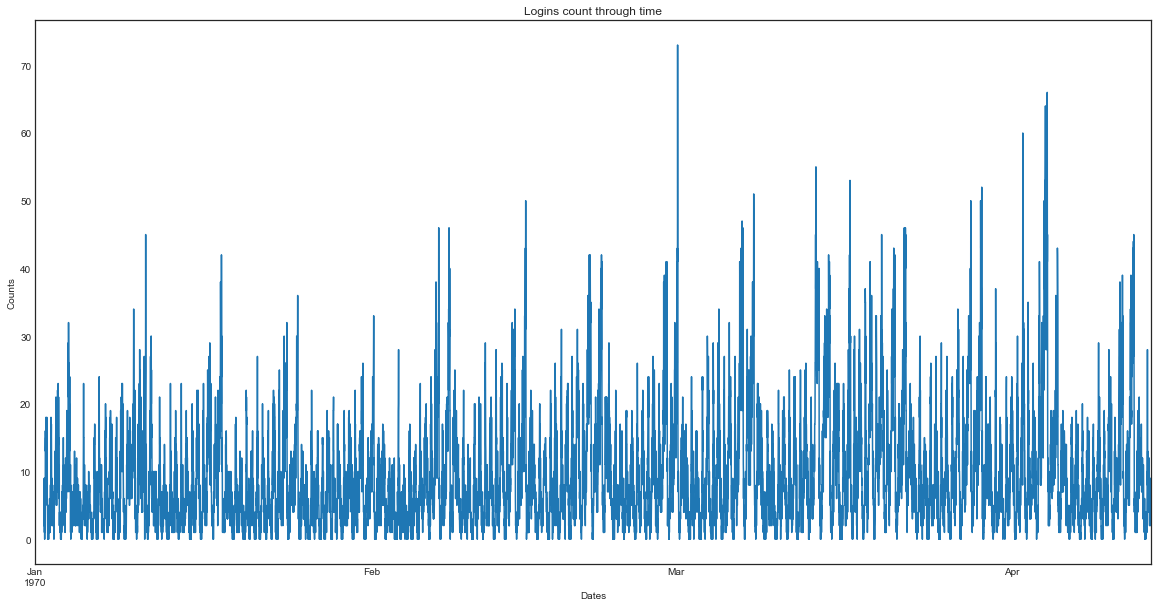

In [4]:
# Configs
first_date = ts.index[0].strftime('%Y-%m-%d')
last_date = ts.index[-1].strftime('%Y-%m-%d')
xticks = pd.date_range(first_date, last_date, freq='D')

# series plot
ts.plot(figsize=(20,10), xticks=xticks.to_pydatetime())
plt.title('Logins count through time')
plt.xlabel('Dates')
plt.ylabel('Counts')

Text(0, 0.5, 'Count')

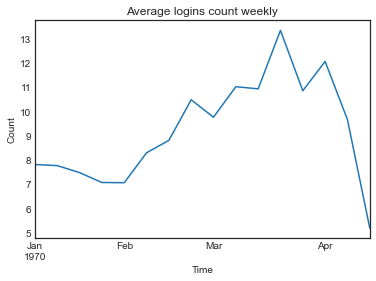

In [5]:
# Average login counts
ts.resample('W').mean().plot()
plt.title('Average logins count weekly')
plt.xlabel('Time')
plt.ylabel('Count')

Text(0.5, 1.0, 'Logins histogram (15 mins interval)')

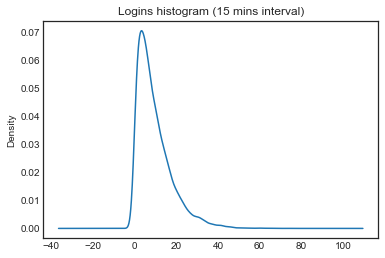

In [6]:
# Histogram of logins within 15 minutes
ts.plot(kind='kde')
plt.title('Logins histogram (15 mins interval)')

# Weekly trend

First, lets confirm that weekdays has less demand by looking at day
of the week for 1970-01-05.

In [7]:
# what day has low demand
ts['1970-01-02'].index[0].strftime('%A')

'Friday'

Now, lets zoom in on just one particular week of January. Friday to Sunday
see the most demands.

Text(0, 0.5, 'Count')

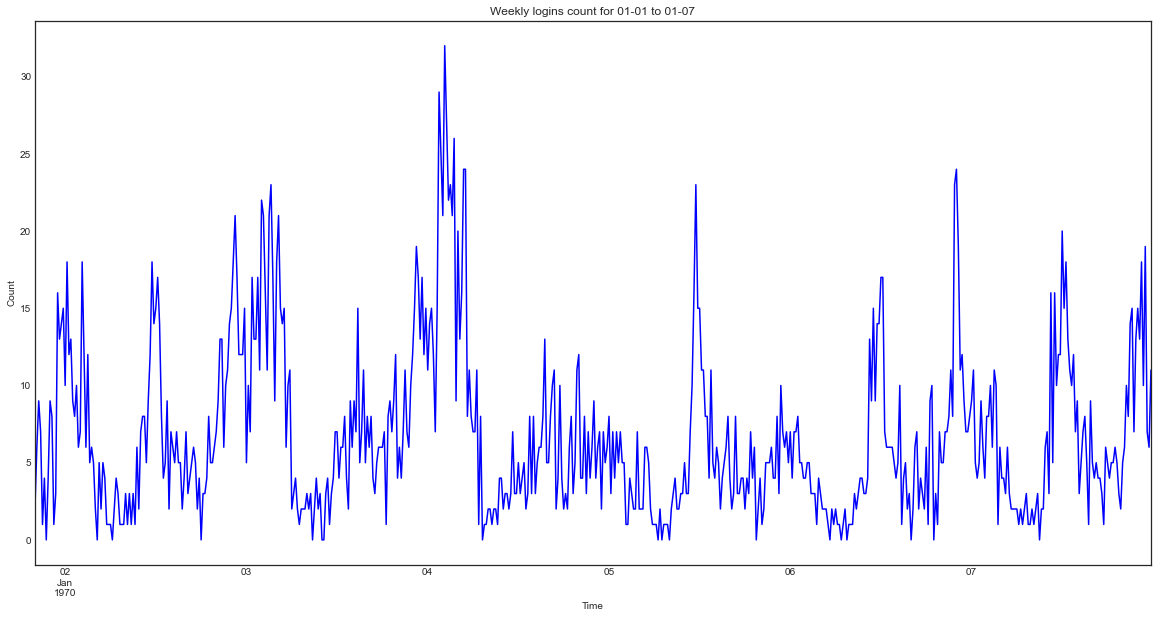

In [8]:
# weekly demand
ts['1970-01-01':'1970-01-07'].plot(figsize=(20,10), style='b')
plt.title('Weekly logins count for 01-01 to 01-07')
plt.xlabel('Time')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

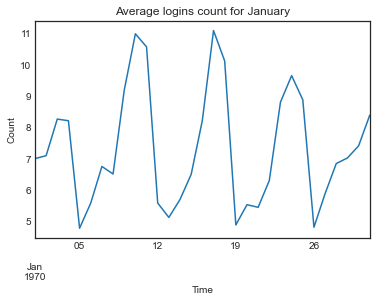

In [9]:
# Average counts for January
ts[ts.index.month == 1].resample('D').mean().plot()
plt.title('Average logins count for January')
plt.xlabel('Time')
plt.ylabel('Count')

Lastly, lets take a quick look at the daily cycle.

The daily cycle is fairly consistent throughout the month. Thus, taking a
look at an arbitrary week will give some useful insights.

Weekdays have the most demands around noon and 9 PM.
Weekends have the lowest demand at noon and constant demands throughout the day
. Moreover, there are peeks at 1-3 AM on weekends.

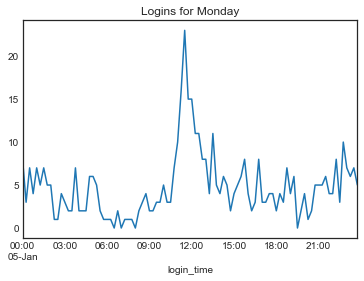

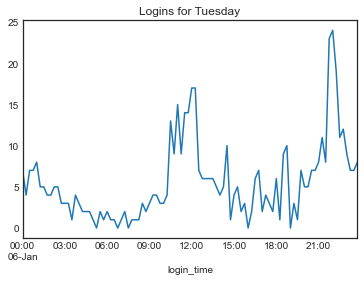

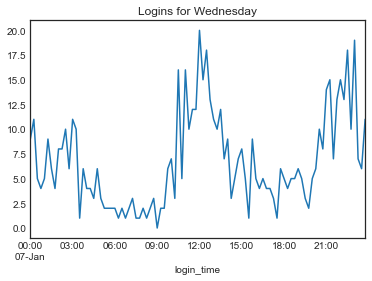

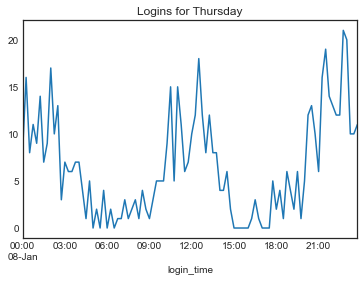

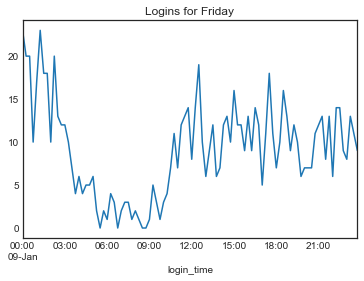

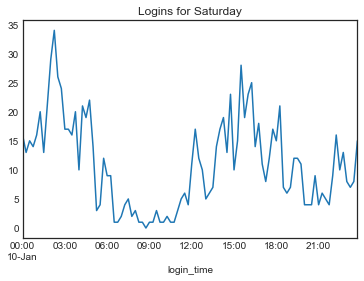

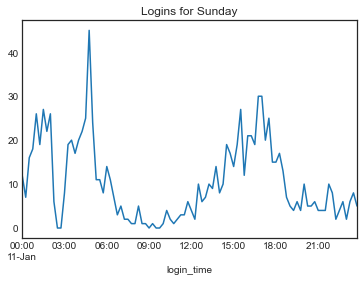

In [10]:
# A range of day
day_list = ['1970-01-05','1970-01-06','1970-01-07','1970-01-08',
            '1970-01-09','1970-01-10','1970-01-11']

# for weekdays
for day in day_list:
    plt.figure()
    ts[day].plot()
    title = ts[day].index[0].strftime('%A')
    plt.title(f'Logins for {title}')


## Part 2 - Metrics Design

Metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

1. The best measure of success would be the percentage of drivers who change
their service from 1 city to 2 city. Since we are most interested in the
effectiveness of the policy, the increase in EXISTING drivers for both city
and not the total numbers that is important.

2. The practical experiment is as followed:
    - Record the data on existing driver partners and their service area. Lets
    give each a number describe the number of cities they serve (1 or 2)
    - Implement the toll reimbursement
    - Again, record the number of city those existing drivers now serve.
    - First measure would be the percentage change in those switching from 1 to 2
    - Secondly, do a statistical test on average (mean) of the the nunber of
    city driver serve. If there is a statistically significant increase, the
    experiment is successful.
    - Shortfall: did not implement the daily traffic cycle for each city into account.
    However, this experiment is fast and easy to implement.
    - Improvement: record many other statistics for classification modeling determine
    the number of city driver serve => get the most important factor that
    influence it.

## Part 3 - Modeling

The following model is used to predict rider retention (active in last 30 days)

### Cleaning data

Some important cleaning steps:
1. There are many missing rows for avg_rating of driver. Two ways of solving this:
    - Discard the features - not in this case since data is small
    - Fill in. Mean is the fastest way for a quick fix. However,
    spending more time to explore the data before filling in is better
    on a big project.
2. phone and avg_rating_by_driver has some missing value that can be discarded - very few
3. Create user retained column. Since the problem did not provide when was the
data is pulled, use last 30 days from the last day of last_trip_date column.
4. Since all the users here sign up in January, signup_date column is also dropped.
5. Boolean and category features (city, phone, and ultimate_black_user) will be converted to numeric after EDA


In [11]:
# first look at the data
print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
# df2 will be the cleaned version
df2 = df.copy()

# Fill in missing value for ag_rating_of_driver
df2.avg_rating_of_driver = df2.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())

# Discard a few missing value from phone and driver rating
df2 = df2.dropna()

# Drop signup_date column
df2 = df2.drop('signup_date', axis=1)

# Convert last_trip_date to datetime and create active column
# Afterward, drop the last_trip_date column
df2.last_trip_date = pd.to_datetime(df2.last_trip_date, format='%Y-%m-%d')
df2['active'] = abs(df2.last_trip_date.max() - df2.last_trip_date).dt.days < 30
df2 = df2.drop('last_trip_date', axis=1)

# Convert boolean into 1 and 0
for i in ['city', 'phone', 'ultimate_black_user', 'active']:
    df2[i] = df2[i].astype('category').cat.codes

### Very brief EDA

Some insights:
1. Active customers tends to take more and longer trips in their first
30 days of signing up.
2. rating of and by driver seems uncorrelated.
3. Rating of driver doesn't seem to affect customer retention.

Text(0.5, 1.0, 'Avg distance vs number of trips')

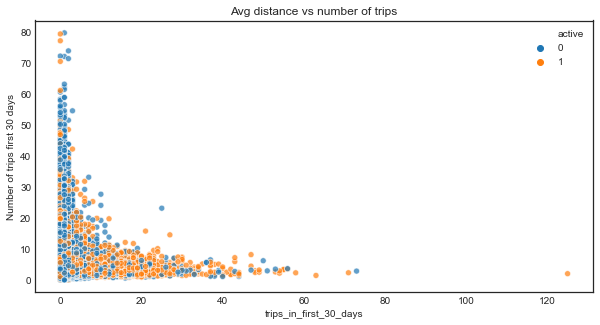

In [13]:
# Initial impression of the service and user retention after 6 months
plt.figure(figsize=(10,5))
sns.scatterplot('trips_in_first_30_days', 'avg_dist', hue='active',
                data=df2, alpha=0.7)
plt.ylabel('Average distance of trip first 30 days')
plt.ylabel('Number of trips first 30 days')
plt.title('Avg distance vs number of trips')

Text(0.5, 1.0, 'Rating of and by driver')

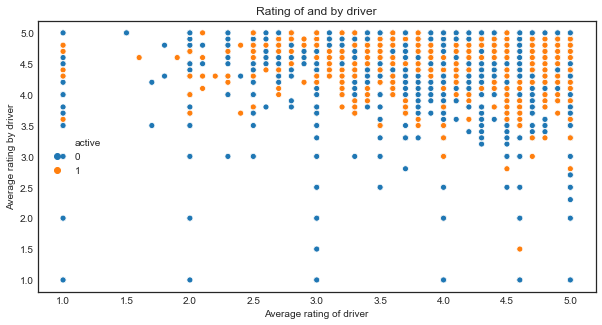

In [14]:
# Driver ratings
plt.figure(figsize=(10,5))
sns.scatterplot('avg_rating_of_driver', 'avg_rating_by_driver',
                hue='active', data=df2)
plt.ylabel('Average rating by driver')
plt.xlabel('Average rating of driver')
plt.title('Rating of and by driver')

Text(0, 0.5, 'Average rating of driver')

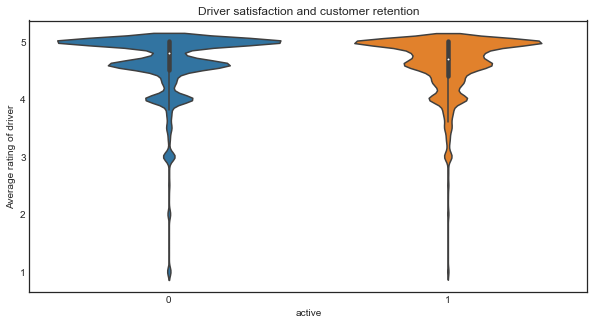

In [15]:
# driver satisfaction and customer retention
plt.figure(figsize=(10,5))
sns.violinplot('active','avg_rating_of_driver',data=df2)
plt.title('Driver satisfaction and customer retention')
plt.ylabel('Average rating of driver')

### Model

Ultimate retained about 37% of customers who signed up in January 2014

Random forest will be the model of choice here since it gives a very
performance for quick analysis. Moreover, it works with many type
of different data. (all hyper-parameters are optimized by randomize grid search)

10% of data will be held back for testing accuracy

In [16]:
# Fraction of retained customers
df2.active.value_counts(normalize=True)

0    0.632717
1    0.367283
Name: active, dtype: float64

In [17]:
# Import
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from pprint import pprint

In [18]:
# Split X and y
X = df2.drop('active', axis=1)
y = df2['active']

# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=41)

In [19]:
# initialize random forest
rf = RandomForestClassifier()

# All hyper-parameter for random forest
print('All hyper-parameters for Random Forest Classifier: \n')
pprint(rf.get_params())

All hyper-parameters for Random Forest Classifier: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Creating random grid

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(100, 1000, num=10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [30]:
# Fit model using 3-fold
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [38]:
# Best Training set score from random search
print('Best training set score: ', rf_random.best_score_)

# Testing set score
y_pred = rf_random.best_estimator_.predict(X_test)
print('Test set score')
print(classification_report(y_test, y_pred))

Best training set score:  0.788238018136536
Test set score
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3157
           1       0.73      0.65      0.69      1784

    accuracy                           0.79      4941
   macro avg       0.77      0.76      0.76      4941
weighted avg       0.78      0.79      0.78      4941



Accuracy is at about 78-79%. Note that this is without tuning the original
data for better fit. There is also no normalization before fitting.

Finally taking a look at feature importance for insights:
1. retained customers travels long distance in the first 30 days
with good rating FROM driver. Moreover, they tends to travel during
weekdays with surge multiplier > 1
2. customer's home city has medium impact on retention
3. All features seems useful in determining customer retention.

In [43]:
# Feature importance of best model
pd.Series(rf_random.best_estimator_.feature_importances_, index=X.columns)

city                      0.109407
trips_in_first_30_days    0.074354
avg_rating_of_driver      0.058781
avg_surge                 0.085595
phone                     0.064151
surge_pct                 0.117878
ultimate_black_user       0.051086
weekday_pct               0.131202
avg_dist                  0.155799
avg_rating_by_driver      0.151746
dtype: float64

How to leverage this ?

Ultimate should focus on customers who travels a lot in their first 30 days
and with good rating FROM driver by offering discounts and promotion.
Moreover, increasing incentives for traveling weekdays is also good!

